In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.11.0'

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

### Import and Preprocess the dataset

You will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

##Converting the images to float and normalizing them from -1 to 1 that helps the model to learn better.

In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

Use the (as yet untrained) generator to create an image.

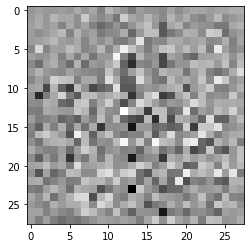

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization_3 (Batc  (None, 12544)            50176     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 12544)             0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 7, 7, 128)        819200    
 ranspose)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 7, 7, 128)       

### The Discriminator

The discriminator is a CNN-based image classifier.

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00256441]], shape=(1, 1), dtype=float32)


In [ ]:
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 6272)             

## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since you will train two networks separately.

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

#Function To Plot discriminator and generator losses during training

In [ ]:
# Define lists to store losses
generator_losses = []
discriminator_losses = []


In [ ]:
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
      error = gen_loss + disc_loss
      
   
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    # Add losses to lists
    generator_losses.append(gen_loss)
    discriminator_losses.append(disc_loss)

    return error

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)
    
    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    
  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,epochs,seed)

**Generate and save images**


In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

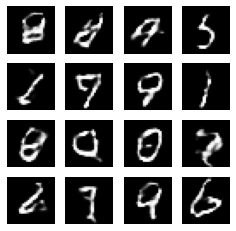

In [ ]:
train(train_dataset, EPOCHS)

Restore the latest checkpoint.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

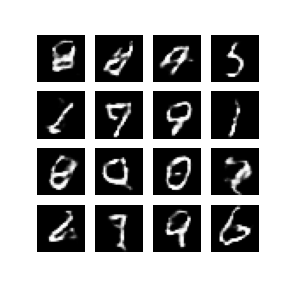

In [ ]:
display_image(EPOCHS)

1875/1875 [==============================] - 3s 2ms/step


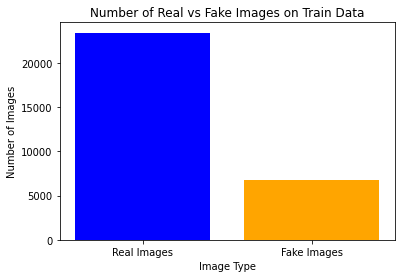

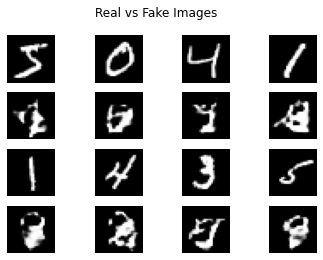

In [ ]:
# Load the generator model
gen = generator

# Load the trained discriminator model
dis = discriminator

# Generate fake images
noise = np.random.normal(0, 1, (train_images.shape[0], 100))
generated_images = gen.predict(noise)

# Evaluate the trained discriminator on the test dataset
real_preds = dis.predict(train_images)
fake_preds = dis.predict(generated_images)

# Count the number of real and fake images
num_real = np.sum(real_preds >= 0.5)
num_fake = np.sum(fake_preds < 0.5)

# Plot the bar graph
labels = ['Real Images', 'Fake Images']
values = [num_real, num_fake]
colors = ['blue', 'orange']
plt.bar(labels, values, color=colors)
plt.title('Number of Real vs Fake Images on Train Data')
plt.xlabel('Image Type')
plt.ylabel('Number of Images')
plt.show()
# Plot the real vs fake images
fig, axs = plt.subplots(4, 4)
fig.suptitle('Real vs Fake Images')
for i in range(4):
    for j in range(4):
        if i % 2 == 0:
            axs[i, j].imshow(train_images[i // 2 * 8 + j], cmap='gray')
        else:
            axs[i, j].imshow(generated_images[(i // 2 * 8 + j) - 8], cmap='gray')
        axs[i, j].axis('off')
plt.show()

In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
(X_train, _), (_, _) = mnist.load_data()

# Rescale -1 to 1
X_train = X_train / 127.5 - 1.
X_train = np.expand_dims(X_train, axis=3)

# Set the input shape
img_shape = (28, 28, 1)

# Define the generator

# Compile the discriminator
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(0.0002, 0.5),
                      metrics=['accuracy'])

# Define the combined GAN model

z = Input(shape=(100,))
img = generator(z)

discriminator.trainable = False

validity = discriminator(img)

combined = Model(z, validity)
combined.compile(loss='binary_crossentropy',
                 optimizer=Adam(0.0002, 0.5))

# Train the GAN
epochs = 50
batch_size = 128
sample_interval = 1000
d_loss_list = []
g_loss_list = []
acc_list = []
loss_per =[]
for epoch in range(epochs):

    # Train the discriminator
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_imgs = X_train[idx]
    
    # Generate fake images
    noise = np.random.normal(0, 1, (batch_size, 100))
    fake_imgs = generator.predict(noise)

    # Count number of real and fake images
    num_real_imgs = real_imgs.shape[0]
    num_fake_imgs = fake_imgs.shape[0]
    
    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(real_imgs, np.ones((batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch(fake_imgs, np.zeros((batch_size, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train the generator
    noise = np.random.normal(0, 1, (batch_size, 100))
    g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))

    # Print the progress
    print("Epoch:", epoch, "D Loss:", d_loss[0], "Accuracy:", 100 * d_loss[1], "G Loss:", g_loss)
    d_loss_list.append(d_loss[0])
    g_loss_list.append(g_loss)
    acc_list.append(100*d_loss[1])
    loss_per.append((1-d_loss[1])*100)


4/4 [==============================] - 0s 5ms/step
Epoch: 0 D Loss: 6.961807727813721 Accuracy: 30.859375 G Loss: 1.016129732131958
4/4 [==============================] - 0s 3ms/step
Epoch: 1 D Loss: 7.558024883270264 Accuracy: 30.46875 G Loss: 0.9807065725326538
4/4 [==============================] - 0s 3ms/step
Epoch: 2 D Loss: 7.54557204246521 Accuracy: 30.46875 G Loss: 0.9943292140960693
4/4 [==============================] - 0s 3ms/step
Epoch: 3 D Loss: 7.046640396118164 Accuracy: 30.859375 G Loss: 1.0203649997711182
4/4 [==============================] - 0s 3ms/step
Epoch: 4 D Loss: 7.332949876785278 Accuracy: 34.765625 G Loss: 1.2753891944885254
4/4 [==============================] - 0s 3ms/step
Epoch: 5 D Loss: 6.346685409545898 Accuracy: 39.0625 G Loss: 1.0551079511642456
4/4 [==============================] - 0s 3ms/step
Epoch: 6 D Loss: 7.066640377044678 Accuracy: 31.640625 G Loss: 0.683368980884552
4/4 [==============================] - 0s 3ms/step
Epoch: 7 D Loss: 7.708686

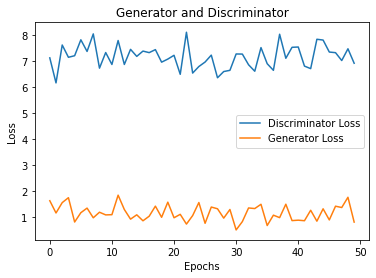

In [ ]:
plt.plot(d_loss_list, label='Discriminator Loss')
plt.plot(g_loss_list, label='Generator Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Generator and Discriminator')
plt.legend()
plt.show()

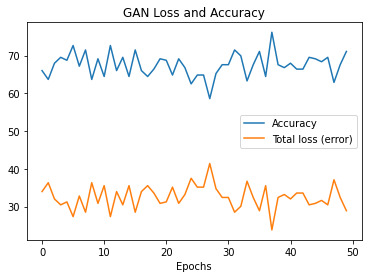

In [ ]:
plt.plot(loss_per, label='Accuracy')
plt.plot(acc_list, label='Total loss (error)')
plt.xlabel('Epochs')
plt.title('GAN Loss and Accuracy')
plt.legend()
plt.show()

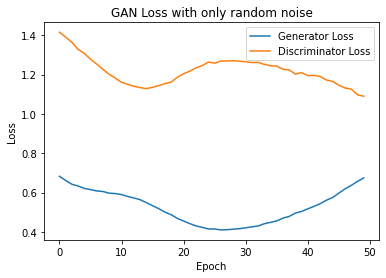

In [ ]:
plt.plot(generator_losses[:50], label='Generator Loss')
plt.plot(discriminator_losses[:50], label='Discriminator Loss')
plt.legend()
plt.title('GAN Loss with only random noise')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()